# 第三题

## 数据处理

In [ ]:
# import pandas as pd
# import os
# import numpy as np

# def process_excel_to_csv(excel_file, output_folder='./data'):
#     """
#     处理Excel文件中的所有sheet，将其转换为CSV文件存放在data文件夹中
    
#     参数:
#     excel_file: Excel文件路径
#     output_folder: 输出文件夹路径
#     """
#     # 确保输出文件夹存在
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)
#         print(f"创建文件夹: {output_folder}")
    
#     # 读取Excel文件的所有sheet
#     print(f"读取Excel文件: {excel_file}")
#     excel_data = pd.read_excel(excel_file, sheet_name=None)
    
#     # 处理每个sheet并保存为CSV
#     for sheet_name, df in excel_data.items():
#         # 确定输出文件名
#         if sheet_name=="RGB目标值":
#             sheet_name="RGB_in"
#         output_file = f"{sheet_name}.csv"
#         output_path = os.path.join(output_folder, output_file)

#         # 将数据保存为CSV（不带索引和列名）
#         df.to_csv(output_path, index=False, header=False)
#         print(f"已将sheet '{sheet_name}' 保存为: {output_path}")
    
#     print("所有数据处理完成!")

# # 使用函数
# if __name__ == "__main__":
#     excel_file = "B题附件：RGB数值（0601更新）.xlsx"  # Excel文件路径
#     output_folder = "./data"  # 输出文件夹路径
    
#     process_excel_to_csv(excel_file, output_folder)

读取Excel文件: B题附件：RGB数值（0601更新）.xlsx
已将sheet 'RGB_in' 保存为: ./data\RGB_in.csv
已将sheet 'R_R' 保存为: ./data\R_R.csv
已将sheet 'R_G' 保存为: ./data\R_G.csv
已将sheet 'R_B' 保存为: ./data\R_B.csv
已将sheet 'G_R' 保存为: ./data\G_R.csv
已将sheet 'G_G' 保存为: ./data\G_G.csv
已将sheet 'G_B' 保存为: ./data\G_B.csv
已将sheet 'B_R' 保存为: ./data\B_R.csv
已将sheet 'B_G' 保存为: ./data\B_G.csv
已将sheet 'B_B' 保存为: ./data\B_B.csv
所有数据处理完成!


## 校色过程

In [2]:
import numpy as np
import pandas as pd
import os

def load_data(folder):
    def read(name):
        return pd.read_csv(os.path.join(folder, name), header=None).values

    return {
        "R_R": read("R_R.csv"),
        "R_G": read("R_G.csv"),
        "R_B": read("R_B.csv"),
        "G_R": read("G_R.csv"),
        "G_G": read("G_G.csv"),
        "G_B": read("G_B.csv"),
        "B_R": read("B_R.csv"),
        "B_G": read("B_G.csv"),
        "B_B": read("B_B.csv"),
    }

def compute_correction_matrices(data):
    H, W = data["R_R"].shape
    M_inv_all = np.zeros((H, W, 3, 3))  # 64x64x3x3
    
    input_vecs = np.array([
        [220, 0, 0],
        [0, 220, 0],
        [0, 0, 220]
    ])  # Shape: (3, 3)

    A = input_vecs.T  # (3,3)

    for i in range(H):
        for j in range(W):
            B = np.array([
                [data["R_R"][i,j], data["G_R"][i,j], data["B_R"][i,j]],
                [data["R_G"][i,j], data["G_G"][i,j], data["B_G"][i,j]],
                [data["R_B"][i,j], data["G_B"][i,j], data["B_B"][i,j]],
            ])  # 3x3

            try:
                M = np.linalg.lstsq(A.T, B.T, rcond=None)[0].T  # A @ M = B → solve M
                if np.linalg.det(M) == 0:
                    M_inv = np.linalg.pinv(M)   # SVD pseudo-inverse
                else:
                    M_inv = np.linalg.inv(M)
            except np.linalg.LinAlgError:
                M_inv = np.eye(3)  # fallback

            M_inv_all[i,j] = M_inv

    return M_inv_all

def apply_color_correction(img_data, M_inv_all):
    H, W, _ = img_data.shape
    corrected_img = np.zeros_like(img_data, dtype=np.float32)

    for i in range(H):
        for j in range(W):
            inp = img_data[i,j]
            M_inv = M_inv_all[i,j]
            corrected_rgb = M_inv @ inp
            corrected_img[i,j] = np.clip(corrected_rgb, 0, 255)

    return corrected_img.astype(np.uint8)





## 成果评估

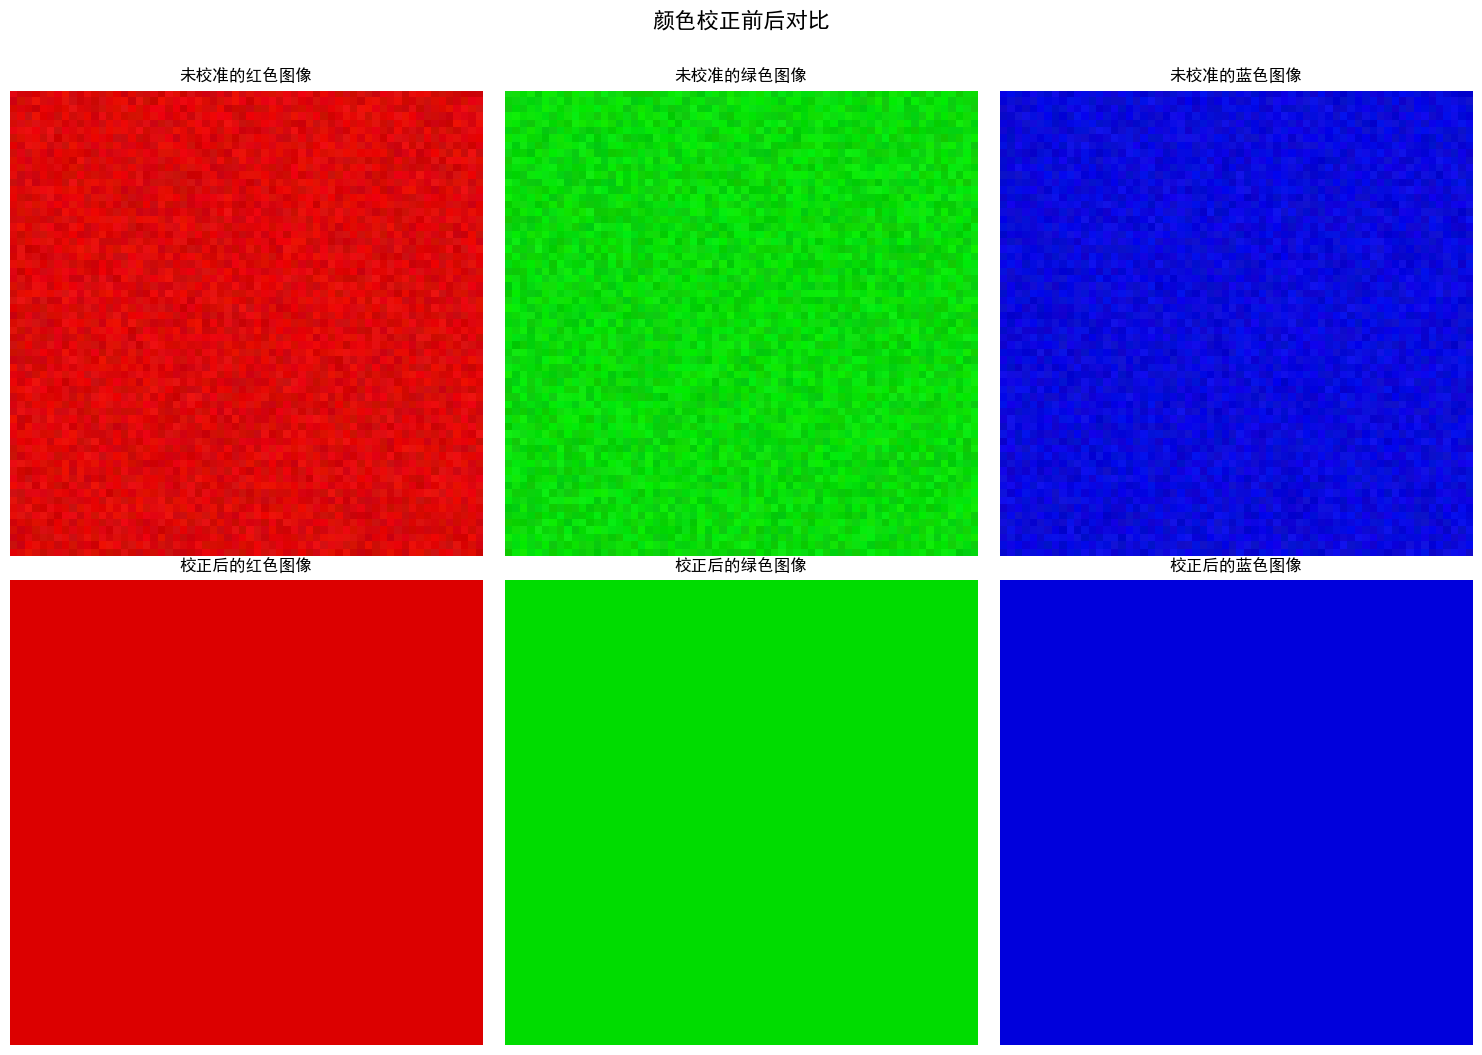

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

def generate_comparison_images(data_folder="./data"):
    # 1. 加载数据并计算校正矩阵
    data = load_data(data_folder)
    M_inv_all = compute_correction_matrices(data)
    
    # 2. 获取图像尺寸
    H, W = data["R_R"].shape  # 应该是64x64
    
    # 3. 构建实际测量的未校准RGB图像（使用测量数据）
    # 未校准的红色图像
    uncorrected_red = np.zeros((H, W, 3), dtype=np.uint8)
    uncorrected_red[..., 0] = data["R_R"][:64, :64]  # R通道
    uncorrected_red[..., 1] = data["R_G"][:64, :64]  # G通道
    uncorrected_red[..., 2] = data["R_B"][:64, :64]  # B通道
    
    # 未校准的绿色图像
    uncorrected_green = np.zeros((H, W, 3), dtype=np.uint8)
    uncorrected_green[..., 0] = data["G_R"][:64, :64]  # R通道
    uncorrected_green[..., 1] = data["G_G"][:64, :64]  # G通道
    uncorrected_green[..., 2] = data["G_B"][:64, :64]  # B通道
    
    # 未校准的蓝色图像
    uncorrected_blue = np.zeros((H, W, 3), dtype=np.uint8)
    uncorrected_blue[..., 0] = data["B_R"][:64, :64]  # R通道
    uncorrected_blue[..., 1] = data["B_G"][:64, :64]  # G通道
    uncorrected_blue[..., 2] = data["B_B"][:64, :64]  # B通道
    
    # 4. 创建纯色输入图像（用于校正）
    red_input = np.zeros((H, W, 3), dtype=np.uint8)
    red_input[..., 0] = 220  # R通道
    
    green_input = np.zeros((H, W, 3), dtype=np.uint8)
    green_input[..., 1] = 220  # G通道
    
    blue_input = np.zeros((H, W, 3), dtype=np.uint8)
    blue_input[..., 2] = 220  # B通道
    
    # 5. 应用颜色校正
    corrected_red = apply_color_correction(uncorrected_red, M_inv_all)
    corrected_green = apply_color_correction(uncorrected_green, M_inv_all)
    corrected_blue = apply_color_correction(uncorrected_blue, M_inv_all)
    
    # 6. 创建对比图
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 显示未校准的实际测量图像（上排）
    axes[0, 0].imshow(uncorrected_red)
    axes[0, 0].set_title('未校准的红色图像')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(uncorrected_green)
    axes[0, 1].set_title('未校准的绿色图像')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(uncorrected_blue)
    axes[0, 2].set_title('未校准的蓝色图像')
    axes[0, 2].axis('off')
    
    # 显示校正后的图像（下排）
    axes[1, 0].imshow(corrected_red)
    axes[1, 0].set_title('校正后的红色图像')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(corrected_green)
    axes[1, 1].set_title('校正后的绿色图像')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(corrected_blue)
    axes[1, 2].set_title('校正后的蓝色图像')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.suptitle('颜色校正前后对比', fontsize=16, y=1.05)
    plt.savefig('color_correction_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 7. 返回图像用于后续分析
    return {
        'uncorrected': {
            'red': uncorrected_red,
            'green': uncorrected_green,
            'blue': uncorrected_blue
        },
        'corrected': {
            'red': corrected_red,
            'green': corrected_green,
            'blue': corrected_blue
        }
    }

# 确保中文正确显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 生成对比图
images = generate_comparison_images()

In [4]:
def calculate_color_differences(data_folder="./data"):

    # 1. 加载数据并计算校正矩阵
    data = load_data(data_folder)
    M_inv_all = compute_correction_matrices(data)
    
    # 2. 获取图像尺寸
    H, W = data["R_R"].shape  # 应该是64x64
    
    # 3. 构建实际测量的未校准RGB图像（使用测量数据）
    # 未校准的红色图像
    uncorrected_red = np.zeros((H, W, 3), dtype=np.uint8)
    uncorrected_red[..., 0] = data["R_R"][:64, :64]  # R通道
    uncorrected_red[..., 1] = data["R_G"][:64, :64]  # G通道
    uncorrected_red[..., 2] = data["R_B"][:64, :64]  # B通道
    
    # 未校准的绿色图像
    uncorrected_green = np.zeros((H, W, 3), dtype=np.uint8)
    uncorrected_green[..., 0] = data["G_R"][:64, :64]  # R通道
    uncorrected_green[..., 1] = data["G_G"][:64, :64]  # G通道
    uncorrected_green[..., 2] = data["G_B"][:64, :64]  # B通道
    
    # 未校准的蓝色图像
    uncorrected_blue = np.zeros((H, W, 3), dtype=np.uint8)
    uncorrected_blue[..., 0] = data["B_R"][:64, :64]  # R通道
    uncorrected_blue[..., 1] = data["B_G"][:64, :64]  # G通道
    uncorrected_blue[..., 2] = data["B_B"][:64, :64]  # B通道
    
    # 5. 应用颜色校正
    corrected_red = apply_color_correction(uncorrected_red, M_inv_all)
    corrected_green = apply_color_correction(uncorrected_green, M_inv_all)
    corrected_blue = apply_color_correction(uncorrected_blue, M_inv_all)

    # 创建标准颜色目标
    red_target = np.array([220, 0, 0])
    green_target = np.array([0, 220, 0])
    blue_target = np.array([0, 0, 220])
    
    # 计算未校正图像的平均RGB值
    red_uncorrected_avg = np.mean(uncorrected_red, axis=(0, 1))
    green_uncorrected_avg = np.mean(uncorrected_green, axis=(0, 1))
    blue_uncorrected_avg = np.mean(uncorrected_blue, axis=(0, 1))
    
    # 计算校正后图像的平均RGB值
    red_corrected_avg = np.mean(corrected_red, axis=(0, 1))
    green_corrected_avg = np.mean(corrected_green, axis=(0, 1))
    blue_corrected_avg = np.mean(corrected_blue, axis=(0, 1))
    
    # 计算欧氏距离色差
    red_uncorr_diff = np.sqrt(np.sum((red_uncorrected_avg - red_target)**2))
    red_corr_diff = np.sqrt(np.sum((red_corrected_avg - red_target)**2))
    
    green_uncorr_diff = np.sqrt(np.sum((green_uncorrected_avg - green_target)**2))
    green_corr_diff = np.sqrt(np.sum((green_corrected_avg - green_target)**2))
    
    blue_uncorr_diff = np.sqrt(np.sum((blue_uncorrected_avg - blue_target)**2))
    blue_corr_diff = np.sqrt(np.sum((blue_corrected_avg - blue_target)**2))
    
    # 打印结果
    print(f"红色校正前色差: {red_uncorr_diff:.4f}, 校正后: {red_corr_diff:.4f}")
    print(f"绿色校正前色差: {green_uncorr_diff:.4f}, 校正后: {green_corr_diff:.4f}")
    print(f"蓝色校正前色差: {blue_uncorr_diff:.4f}, 校正后: {blue_corr_diff:.4f}")

# 添加到generate_comparison_images函数末尾
calculate_color_differences()

红色校正前色差: 13.3831, 校正后: 0.0000
绿色校正前色差: 13.3472, 校正后: 0.0000
蓝色校正前色差: 13.4450, 校正后: 0.0000
